Yelp NLP project 

Part Two of Four

Raymond Leong

# Extracting entities and Feature Engineering different variables

## Business Problem

The business problem for any restaurant owner is to retain customers and attract new ones. For stake holders that have multiple businesses in the PA area there are key features related to either hospitality or food quality, there is very little room for other attributes that are measurable. Average wait time, complaints and concerns, responsiveness, freebies, hygien are all attributes that were not measured (https://www.posist.com/restaurant-times/restro-gyaan/ways-to-improve-restaurant-service.html). This means that attributes related to serice and food quality can be measured through means of NLP. Additionally we can feature engineer some more variables that can add onto other models when needed.

- Notebook 2(Business problem identification and FE):
This notebook will focus on finding the PA resturants and develop our business problem further through data cleanring (of attributes and hours) entity extraction of nouns and adjectives, vader sentiment, distance calculation between establishments, distance measurement between words, modeling with the best model in notebook 1

- 1. We break down the 2 dictionary column (attributes and hours) in order to examine the trends of PA Resturants

- 2. We will extract the nouns and adjectives, visualize it and run a small model to confirm our accuracy. 

We will start with normalizing the business dataset



In [1]:
#Like notebook 1 we will break down the attributes and hours columns from business
import pandas as pd
pd.set_option('mode.chained_assignment', None)
business = pd.read_json('yelp_academic_dataset_business.json', lines =True)
business_attributes = pd.json_normalize(business['attributes'])
business_hours = pd.json_normalize(business['hours'])


In [2]:
business_attributes.columns

Index(['ByAppointmentOnly', 'BusinessAcceptsCreditCards', 'BikeParking',
       'RestaurantsPriceRange2', 'CoatCheck', 'RestaurantsTakeOut',
       'RestaurantsDelivery', 'Caters', 'WiFi', 'BusinessParking',
       'WheelchairAccessible', 'HappyHour', 'OutdoorSeating', 'HasTV',
       'RestaurantsReservations', 'DogsAllowed', 'Alcohol', 'GoodForKids',
       'RestaurantsAttire', 'Ambience', 'RestaurantsTableService',
       'RestaurantsGoodForGroups', 'DriveThru', 'NoiseLevel', 'GoodForMeal',
       'BusinessAcceptsBitcoin', 'Smoking', 'Music', 'GoodForDancing',
       'AcceptsInsurance', 'BestNights', 'BYOB', 'Corkage', 'BYOBCorkage',
       'HairSpecializesIn', 'Open24Hours', 'RestaurantsCounterService',
       'AgesAllowed', 'DietaryRestrictions'],
      dtype='object')

We can now see ohe attributes that can be independently explored. This makes it easier for modelling purposes

In [3]:
#use result as a dummy for a consecutive conocating
result = pd.concat([business, business_attributes], axis=1,)

In [4]:
#merge again
business = pd.concat([result, business_hours], axis =1)

In [5]:
#find shape so that you know how many rows we're working with
#in this case its 150346 unique businesses but the columns have expanded to 60 rows
print(business.shape)

(150346, 60)


Break down the categories to filter out PA restuarants

First find all the categories and stack them ontop of each other as seperate entries(rows)

In [6]:
#refer to project one on explanation of this code
#it drops the cateogries and split like a .explode function except it creates duplicates by expanding whenever  the str ","" is present. 
#restack it
#reset index and rename it after adding it in
business_data = business.drop('categories', axis=1).join(business['categories'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('establishment_type'))

In [7]:
#set this as type str for regex prep
business_data['establishment_type'] = business_data['establishment_type'].astype('str')

In [8]:
#acknowledge resturants is # 1 
business_data.establishment_type.value_counts(10)

 Restaurants            0.055299
 Food                   0.031401
 Shopping               0.028286
Restaurants             0.022865
 Home Services          0.015796
                          ...   
 Patent Law             0.000001
LAN Centers             0.000001
Holistic Animal Care    0.000001
Bocce Ball              0.000001
 Trade Fairs            0.000001
Name: establishment_type, Length: 2455, dtype: float64

So the percentage of food and resturants businesses (first two entries above) is around 9.6% youre going to get 19200 out of the 200,000 rows

We can get more if we use regex and make sure each letter has no case sensitivity and spaces before and after it do not matter.

In [9]:
#import re, find the data that only contains resturants and food with no case sensitivity 
import re 
business_dataprep = business_data[business_data['establishment_type'].str.contains('.*Restaurants.*')| business_data['establishment_type'].str.contains('.*Food.*')]

In [10]:
#drop duplicate ids because its the same resturant 
buisness_data_prep = business_dataprep.drop_duplicates(subset=['business_id'], ignore_index= True)

In [11]:
#this now has 64,616 resturants which is almost 3x the expected entries had we not used regex
buisness_data_prep.shape

(64616, 60)

In [12]:
# we now wish to know the cumulative hours of each resturant that it remains open so lets make a copy
buisness_data_prep_copy = buisness_data_prep.copy()

In [13]:
#our first look into the dataframe 
buisness_data_prep_copy.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,AgesAllowed,DietaryRestrictions,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,establishment_type
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,NaN,NaN,7:0-20:0,7:0-20:0,7:0-20:0,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0,Restaurants
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,...,NaN,NaN,NaN,NaN,14:0-22:0,16:0-22:0,12:0-22:0,12:0-22:0,12:0-18:0,Food
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,...,NaN,NaN,0:0-0:0,6:0-22:0,6:0-22:0,6:0-22:0,9:0-0:0,9:0-22:0,8:0-22:0,Fast Food
3,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Restaurants
4,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,...,NaN,NaN,0:0-0:0,6:0-21:0,6:0-21:0,6:0-16:0,6:0-16:0,6:0-17:0,6:0-21:0,Fast Food


In [14]:
#will need this later because we want to compare latittude and longitude 
from geopy import distance

We now filter the amount of resturants to PA

In [15]:
#obtain the data from philly only
geo_example_philly= buisness_data_prep_copy[buisness_data_prep_copy['city'] == ("Philadelphia")]

In [16]:
#we will be working with 7076 unique resturants 
geo_example_philly.shape

(7076, 60)

The code above gives us a df of resturants in philadelphia

The code below will now obtain reviews from yelpreviews, as youve seen previously, and we will now take out all the reviews with businesses in pa that are a resturant in philly

In [17]:
#get yelp reviews so that we can find PA resturants and foods
import json
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.width', 10000)

# open input file: 
ifile = open('yelp_academic_dataset_review-001.json', encoding = 'ascii', errors = 'ignore') 

# read the first 100k entries
# set to -1 to process everything
stop = 600000

all_data = list()
for i, line in enumerate(ifile):
    if i%10000==0:
        print(i)
    if i==stop:
        break    
    # convert the json on this line to a dict
    data = json.loads(line)
    # extract what we want
    text = data['text']
    stars = data['stars']
    user_id = data['user_id']
    business_id= data["business_id"]
    # add to the data collected so far
    all_data.append([stars, text, user_id, business_id])
# create the DataFrame
yelp_reviews_raw = pd.DataFrame(all_data, columns=['stars','text', 'user_id', 'business_id'])


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000


In [20]:
buisness_data_prep_copy.shape

(64616, 60)

In [21]:
#this merges all of our restaurants
yelp_philly_merge= pd.merge(geo_example_philly, yelp_reviews_raw, on='business_id', how ="left")

In [23]:
yelp_philly_merge.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,...,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,establishment_type,stars_y,text,user_id
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,7:0-20:0,7:0-20:0,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0,Restaurants,4.0,This is nice little Chinese bakery in the hear...,6_SpY41LIHZuIaiDs5FMKA
1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,7:0-20:0,7:0-20:0,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0,Restaurants,4.0,This is the bakery I usually go to in Chinatow...,tCXElwhzekJEH6QJe3xs7Q
2,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,7:0-20:0,7:0-20:0,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0,Restaurants,5.0,"A delightful find in Chinatown! Very clean, an...",WqfKtI-aGMmvbA9pPUxNQQ
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,7:0-20:0,7:0-20:0,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0,Restaurants,5.0,I ordered a graduation cake for my niece and i...,3-1va0IQfK-9tUMzfHWfTA
4,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,7:0-20:0,7:0-20:0,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0,Restaurants,4.0,HK-STYLE MILK TEA: FOUR STARS\n\nNot quite su...,EouCKoDfzaVG0klEgdDvCQ


We create a variable for days and find out how many hours each establishment is open for each day.

We will find total hours and weekend hours (F, Sa, Su)

In [25]:
import numpy

In [26]:
#fill na so that the hours are 0
yelp_philly_merge[days] = yelp_philly_merge[days].fillna('1:0-1:0')

In [27]:
# https://stackoverflow.com/questions/64125769/pandas-how-to-extract-and-calculate-the-number-of-hour-per-row-in-a-dataframe
# for this code to work we needed to get rid of the overnight and 24 hour opening
def calculate_hours(row: pd.Series) -> float:
    """
    This code seperates the open hours and minutes from the closed
    Then it seperates the open hours from the open minutes (same for closed)
    Then it calculates a variable called a start time and addd the hour to the minute/60.
    The result is a float that can be used to determine how long the restaurant was opened.
    The result is total hours
    """
    
    try:
        # split the given times to start and end time
        opening_time, closing_time = row.split("-")
        # split hours and minutes
        start_hour, start_minute = opening_time.split(":")
        end_hour, end_minute = closing_time.split(":")
        # calculate start time (in hours)
        start_time = float(start_hour) + float(start_minute) / 60
        # calculate end time (in hours)
        end_time = float(end_hour) + float(end_minute) / 60
        # handle overneight and 24h openings
        if start_time >= end_time:
            end_time += 24
        # return the duration from start time to end time
        return end_time - start_time
    # bare except are not recommended, you should look for your data, what could go wrong
    except:
        return 0.0
   
         


# Save the given data to the new column "open"
# sums up values for each day

days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
yelp_philly_merge["total_hours"] = sum([yelp_philly_merge[day].apply(calculate_hours) for day in days])

In [28]:
yelp_philly_merge['total_hours']

0         94.0
1         94.0
2         94.0
3         94.0
4         94.0
         ...  
73684    168.0
73685     68.0
73686     67.0
73687     64.5
73688     98.0
Name: total_hours, Length: 73689, dtype: float64

Weekend hours

In [29]:
#add all of the weekend hours
yelp_philly_merge["weekend_hours"]=  yelp_philly_merge["Friday"].apply(calculate_hours) +\
             yelp_philly_merge["Saturday"].apply(calculate_hours) +\
             yelp_philly_merge["Sunday"].apply(calculate_hours)

Now we get the average longitude and latitude for philly from code in notebook 1. 

In [30]:
#get the mean
avg_longitude = yelp_philly_merge.groupby('stars_x')['longitude'].mean()

In [31]:
#long
avg_latitude= yelp_philly_merge.groupby('stars_y')['latitude'].mean()

In [32]:
#get it to the frame
avg_latitude= avg_latitude.to_frame(name='lat')

In [33]:
#always reset index
avg_latitude=avg_latitude.reset_index()

In [34]:
#rename one of them into stars 
avg_latitude['stars'] = avg_latitude['stars_y']

In [35]:
#repeat for long
avg_longitude = avg_longitude.to_frame(name='long')

In [36]:
avg_longitude=avg_longitude.reset_index()

In [37]:
avg_longitude['stars'] = avg_longitude['stars_x']

In [38]:
long_lat = pd.merge(avg_latitude, avg_longitude, on = "stars")

In [39]:
#drop original cols
long_lat= long_lat.drop(columns= ['stars_y', 'stars_x'])

In [40]:
#we now have a dataframe where avg long and avg lat are established for a particular star 
long_lat

,lat,stars,long
0,39.968940,1.0,-75.115759
1,39.962735,2.0,-75.151880
2,39.960126,3.0,-75.173699
3,39.960356,4.0,-75.157400
4,39.963655,5.0,-75.150923


In [41]:
#make into dict
star_location = long_lat.set_index('stars').to_dict()

In [42]:
star_location

{'lat': {1.0: 39.96893955131908,
  2.0: 39.96273480454619,
  3.0: 39.96012569298587,
  4.0: 39.96035602539403,
  5.0: 39.96365526059664},
 'long': {1.0: -75.11575871455328,
  2.0: -75.15187980823495,
  3.0: -75.17369886183025,
  4.0: -75.15739993653226,
  5.0: -75.15092345100098}}

In [44]:
#we need a function where we find the distance closeset to the first star 
from geopy.distance import distance
 
def calculate_distance(row):
    """ 
    This calculates the distance between the current dataframe's row's long and lat 
    by looking at the stars in the dataframe
    and then comparing it to the first entry and calculating the distance
    """
    
    star = row['stars_y']
    lat1, long1 = row[['latitude', 'longitude']]
    lat2, long2 = star_location['lat'][stars], star_location['long'][stars]
    return distance((lat1, long1), (lat2, long2)).m

In [46]:
yelp_philly_merge['distance_to_lowest_star'] = yelp_philly_merge.apply(calculate_distance, axis=1)


So now we have a code that allows us to calculate to the nearest distance. This will be useful if we compare it to distances to places people normally find positive such as amusement parks, carnivals, shopping centers, city hall etc.

On the other hand, less attractive destinations that might not garner as much foot traffic such as long empty stretches of land, abandoned buildings, graveyards etc.

We will now find the text refurbished from PA restaurants.

In [47]:
yelp_philly_merge['text'] = yelp_philly_merge.text.astype(str)

In [48]:
#get rid of the nans
yelp_philly_merge = yelp_philly_merge[yelp_philly_merge['text'] .str.contains("nan")==False]


In [50]:
yelp_philly_merge["text"] = yelp_philly_merge["text"].astype(str)

In [51]:
#https://github.com/sharmaroshan/Twitter-Sentiment-Analysis/blob/master/LICENSE
#under license provided, this code was supplied by the NLTK library and github owner above
#adjustments made by me are highlighted. 
import re
import re
import nltk
from nltk import pos_tag#a must need in order for the rest of the packages to work 
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer #three different type of tokenizers that we may use 
from nltk.corpus import stopwords, wordnet# need
from nltk.stem import WordNetLemmatizer #need
sw = stopwords.words('english')

#what other stop wards can be used to that is not representative
sw.extend(['link', 'rt', 
'food', 'review', 'yummy', 'cusine', 'dishes', 'tasty', 'delicious'
'tacos', 'burritos', 'sushi', 'american', 'greek', 'chinese', 'pizza' 'really', 'always', 'rarely' 'ive', 'dont', 'u' 'nice'])
#added all punctuation, made sure # and @ wasnt in there
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~“!'
twitter_re = re.compile('[#@][a-zA-Z]*')
num_re = re.compile('^\d{1}$')
hashtags = re.compile ("#([a-zA-Z0-9_]{1,50})")

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def txt_clean(txt, stop_words=sw):
    # takes in a string and returns a cleaned up string ready for count or tfidf vectorizing
    
    # splitting the text up into words
    t = txt.split(' ')
    # turning the words lowercase
    t = [w.lower() for w in t]
    # removing punctuation
    t = [w.translate(w.maketrans('','', punctuation)) for w in t]
    # removing @'s and #'s which are twitter jargon
    t = [w for w in t if not twitter_re.match(w)]
    t = [w for w in t if not hashtags.match(w)]

    # removing leftover numbers
    t = [w for w in t if not num_re.match(w)]
    # removing stop words and more twitter jargon
    t = [w for w in t if w not in stop_words]
    # removing empty strings
    t = [w for w in t if w]
    
    # word lemmatizing
    t = pos_tag(t)
    t = [(w[0], get_wordnet_pos(w[1])) for w in t]
    lem = WordNetLemmatizer()
    t = [lem.lemmatize(w[0], w[1]) for w in t]
    # joining all the strings together into one
    return ' '.join(t)
yelp_philly_merge['text_refurbished'] = yelp_philly_merge["text"].map(txt_clean)

In [52]:
yelp_philly_merge['text_refurbished']= yelp_philly_merge['text_refurbished'].astype(str)

Here we will find the entities by passing the reurbished text through their POS tag and through chunking.

In [53]:
import nltk
import pandas as pd
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from nltk import word_tokenize, pos_tag, ne_chunk
yelp_philly_merge['entities'] = yelp_philly_merge['text_refurbished'].apply(lambda x: ne_chunk(pos_tag(word_tokenize(x))))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gamer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Gamer\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Gamer\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [54]:
#save
yelp_philly_merge.to_csv('entities.csv')

In [55]:
#entities
yelp_philly_merge['entities']

0        [(nice, JJ), (little, JJ), (bakery, JJ), (hear...
1        [(bakery, NN), (usually, RB), (go, VBP), (chin...
2        [(delightful, JJ), (find, VBP), (chinatown, JJ...
3        [(order, NN), (graduation, NN), (cake, VB), (n...
4        [(hkstyle, JJ), (milk, NN), (tea, IN), (four, ...
                               ...                        
67359    [(cute, JJ), (coffee, NN), (shop, NN), (around...
67360    [(nice, JJ), (cash, NN), (coffee, NN), (spot, ...
67361    [(hand, NN), (best, JJS), (ice, NN), (coffee, ...
67362    [(place, NN), (great, JJ), (super, JJ), (chill...
67363    [(neighborhood, NN), (gem, NN), (owner, NN), (...
Name: entities, Length: 65698, dtype: object

We now have nouns and adjectives from each review that we can seperate!

Text(0.5, 1.02, 'Word analysis through Count Vectorization')

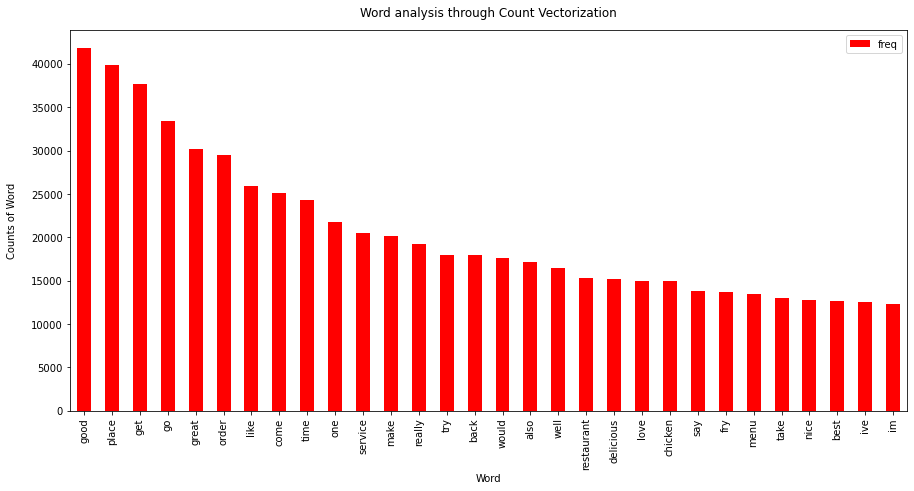

In [56]:
#obtained and adjusted from flatiron
from sklearn.feature_extraction.text import CountVectorizer
#set X to encompass all tweet_text 
X = yelp_philly_merge['text_refurbished']


#use the CV classifier to pass the column without a tokenizer, preprocessor and set lowercase=False 
cv = CountVectorizer(tokenizer=None,
                             preprocessor=None,
                             lowercase=False)
#creates a sparse matrix
words = cv.fit_transform(X)
#add all the values into a variable called sum_words
sum_words = words.sum(axis=0)

#for every word in cv.vocabulary.items (which returns a list), add it to the unique count
#gives off a list of tuples' (item',count) that resembles a pd
words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
#sort by ascending order
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
#create the df
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
#use iloc next time
frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'red')
plt.xlabel("Word")
plt.ylabel("Counts of Word", labelpad=14)
plt.title("Word analysis through Count Vectorization", y=1.02)


In [57]:
yelp_philly_merge['entities']
#yelp_philly_merge['entities_nouns']= yelp_philly_merge['entities'].astype(str).str.contains('\((.*?), NN\)')


0        [(nice, JJ), (little, JJ), (bakery, JJ), (hear...
1        [(bakery, NN), (usually, RB), (go, VBP), (chin...
2        [(delightful, JJ), (find, VBP), (chinatown, JJ...
3        [(order, NN), (graduation, NN), (cake, VB), (n...
4        [(hkstyle, JJ), (milk, NN), (tea, IN), (four, ...
                               ...                        
67359    [(cute, JJ), (coffee, NN), (shop, NN), (around...
67360    [(nice, JJ), (cash, NN), (coffee, NN), (spot, ...
67361    [(hand, NN), (best, JJS), (ice, NN), (coffee, ...
67362    [(place, NN), (great, JJ), (super, JJ), (chill...
67363    [(neighborhood, NN), (gem, NN), (owner, NN), (...
Name: entities, Length: 65698, dtype: object

Finding all the nouns

In [58]:
import pandas as pd
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize


def extract_nouns(text):
    # Tokenize the text data into words
    tokens = word_tokenize(text)

    # Tag the parts of speech in the text
    tagged = pos_tag(tokens)

    # Filter the tagged words to only include the nouns
    filtered_nouns = [word for word, pos in tagged if pos == "NN"]

    # Return the filtered nouns
    return filtered_nouns

# Apply the extract_nouns function to each row in the text_column
yelp_philly_merge['extract_nouns'] = yelp_philly_merge['text_refurbished'].apply(extract_nouns)




In [59]:
yelp_philly_merge['extract_nouns']= yelp_philly_merge['extract_nouns'].astype(str)

In [60]:

yelp_philly_merge['extract_nouns'] = yelp_philly_merge['extract_nouns'].str.strip('[]')

In [61]:

yelp_philly_merge['extract_nouns']

0        'heart', 'philadelphia', 'female', 'cashier', ...
1        'bakery', 'variety', 'bun', 'pastry', 'bun', '...
2        'kind', 'service', 'everyone', 'treat', 'treat...
3          'order', 'graduation', 'event', 'staff', 'nice'
4        'milk', 'saint', 'honore', 'pastry', 'business...
                               ...                        
67359    'coffee', 'shop', 'work', 'price', 'variety', ...
67360    'cash', 'coffee', 'spot', 'cozy', 'spot', 'cof...
67361    'hand', 'ice', 'coffee', 'terrific', 'guy', 'c...
67362    'place', 'chill', 'corner', 'coffee', 'shop', ...
67363    'neighborhood', 'gem', 'owner', 'guy', 'place'...
Name: extract_nouns, Length: 65698, dtype: object

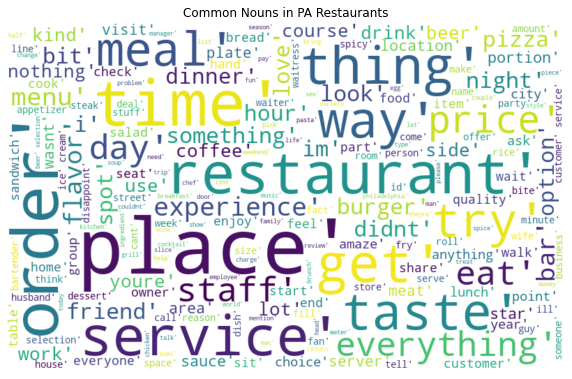

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from wordcloud import WordCloud
nouns =' '.join([text for text in yelp_philly_merge['extract_nouns']])

wordcloud = WordCloud(background_color = 'white', width=800, height=500, random_state = 0, max_font_size = 110).generate(nouns)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Common Nouns in PA Restaurants')
plt.show()


Finding all the Adjectives

In [63]:

def extract_jj(text):
    # Tokenize the text data into words
    tokens = word_tokenize(text)

    # Tag the parts of speech in the text
    tagged = pos_tag(tokens)

    # Filter the tagged words to only include the nouns
    filtered_nouns = [word for word, pos in tagged if pos == "JJ"]

    # Return the filtered nouns
    return filtered_nouns

# Apply the extract_nouns function to each row in the text_column
yelp_philly_merge['extract_adjectives'] = yelp_philly_merge['text_refurbished'].apply(extract_jj)



In [64]:
yelp_philly_merge['extract_adjectives'] = yelp_philly_merge['extract_adjectives'].astype(str)

In [65]:
yelp_philly_merge['extract_adjectives']= yelp_philly_merge['extract_adjectives'].str.strip('[]')

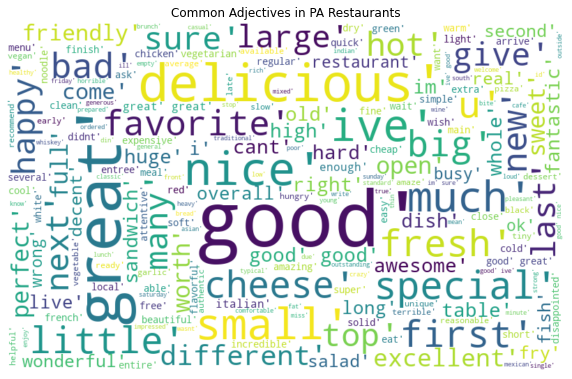

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from wordcloud import WordCloud
adjectives =' '.join([text for text in yelp_philly_merge['extract_adjectives']])

wordcloud = WordCloud(background_color = 'white', width=800, height=500, random_state = 0, max_font_size = 110).generate(adjectives)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Common Adjectives in PA Restaurants')
plt.show()


Now we are going to use our word2vec from gensim model which is a library that looks for semantic similarity (association between words)

In [67]:
from gensim.models import Word2Vec
from nltk import word_tokenize

In [68]:
yelp_philly_merge['text_refurbished']= yelp_philly_merge['text_refurbished'].astype(str)

In [69]:
yelp_philly_merge_preprocesssed = yelp_philly_merge['text_refurbished'].map(word_tokenize)

In [70]:
yelp_philly_merge.to_csv('preprocessed_data.csv')

In [71]:
yelp_philly_merge_preprocesssed

0        [nice, little, bakery, heart, philadelphia, ch...
1        [bakery, usually, go, chinatown, decent, varie...
2        [delightful, find, chinatown, clean, kind, ser...
3        [order, graduation, cake, niece, come, absolut...
4        [hkstyle, milk, tea, four, stars, not, quite, ...
                               ...                        
67359    [cute, coffee, shop, around, corner, work, low...
67360    [nice, cash, coffee, spot, atmosphere, wasnt, ...
67361    [hand, best, ice, coffee, ever, anywhere, ever...
67362    [place, great, super, chill, corner, coffee, s...
67363    [neighborhood, gem, owner, super, nice, guy, t...
Name: text_refurbished, Length: 65698, dtype: object

In [72]:
to_list = yelp_philly_merge_preprocesssed.apply(lambda x: [].append(x))
total = [a for a in yelp_philly_merge_preprocesssed]

In [73]:
yelp_philly_merge_preprocesssed= yelp_philly_merge_preprocesssed.astype(str)

In [74]:
model= None
model = Word2Vec(total, vector_size=100, window=5, min_count=1, workers=4)

In [75]:
word_vectors = model.wv

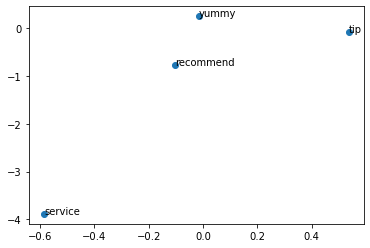

In [76]:
words = ["yummy", "service", "tip", "recommend"]

# Get word vectors for defined words
word_vectors = [word_vectors[word] for word in words]

# Plot word vectors as a 2D scatter plot
x = [v[0] for v in word_vectors]
y = [v[1] for v in word_vectors]
plt.scatter(x, y)

# Annotate points with word labels
for word, x_coord, y_coord in zip(words, x, y):
    plt.annotate(word, (x_coord, y_coord))

# Show plot
plt.show()

We do not have enough statistical evidence to make statements but it seems that recommend and yummy are closer together than tips and service. The closer they are to each other the stronger the association.

The following shows bargraphs associated with a "target word". This is just for exploratory purposes

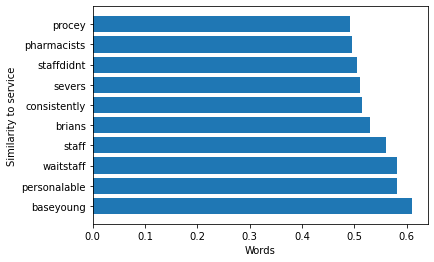

In [77]:
import matplotlib.pyplot as plt

# Define the target word
target_word = "service"

# Get the top 10 most similar words
most_similar = model.wv.most_similar(target_word, topn=10)

# Extract the words and similarity scores
words = [word for word, sim in most_similar]
similarities = [sim for word, sim in most_similar]

# Plot the bar chart
plt.barh(words, similarities)

# Add labels to the x and y axes
plt.xlabel("Words")
plt.ylabel("Similarity to service")

# Show plot
plt.show()

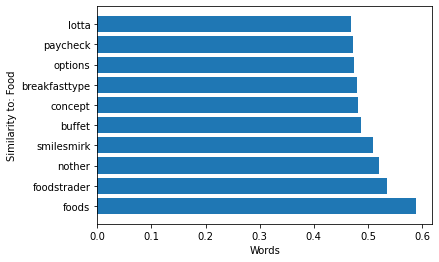

In [78]:
import matplotlib.pyplot as plt

# Load the trained Word2Vec model


# Define the target word
target_word = "food"

# Get the top 10 most similar words
most_similar = model.wv.most_similar(target_word, topn=10)

# Extract the words and similarity scores
words = [word for word, sim in most_similar]
similarities = [sim for word, sim in most_similar]

# Plot the bar chart
plt.barh(words, similarities)

# Add labels to the x and y axes
plt.xlabel("Words")
plt.ylabel("Similarity to: Food")

# Show plot
plt.show()

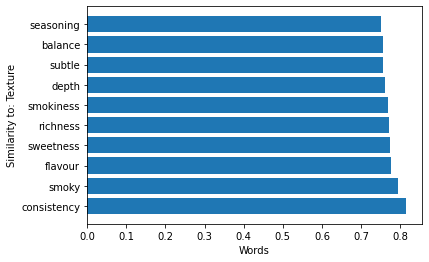

In [79]:
import matplotlib.pyplot as plt

# Load the trained Word2Vec model


# Define the target word
target_word = "texture"

# Get the top 10 most similar words
most_similar = model.wv.most_similar(target_word, topn=10)

# Extract the words and similarity scores
words = [word for word, sim in most_similar]
similarities = [sim for word, sim in most_similar]

# Plot the bar chart
plt.barh(words, similarities)

# Add labels to the x and y axes
plt.xlabel("Words")
plt.ylabel("Similarity to: Texture")

# Show plot
plt.show()

In [80]:
simlar_words_service = model.wv.similar_by_word('service')
print(simlar_words_service)

[('baseyoung', 0.6090383529663086), ('personalable', 0.5819234251976013), ('waitstaff', 0.5814173221588135), ('staff', 0.5608428120613098), ('brians', 0.5300668478012085), ('consistently', 0.5142176747322083), ('severs', 0.5102143883705139), ('staffdidnt', 0.5045871734619141), ('pharmacists', 0.49562007188796997), ('procey', 0.49143171310424805)]


In [81]:
simlar_words_service = ['personable', 'consistently', 'efficient', 'kate', 'paced', 'polite']

In [82]:
similar_words_food = model.wv.similar_by_word('food')
print(similar_words_food)

[('foods', 0.589236319065094), ('foodstrader', 0.5357645153999329), ('nother', 0.5212607383728027), ('smilesmirk', 0.5092446208000183), ('buffet', 0.48654329776763916), ('concept', 0.480838805437088), ('breakfasttype', 0.4803505539894104), ('options', 0.4746055603027344), ('paycheck', 0.4726054072380066), ('lotta', 0.46944907307624817)]


In [83]:
similar_words_food = ['authentic', 'consistent', 'haste', 'sushi']

This is a goldmine of words as we see young, personable, consistency are words that make sense when associated with service. 

# Modeling to see the impact of attributes

In [84]:
#first we import our libraries from keras for NLP
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

In [85]:
#drop what we dont need currently
yelp_philly_merge_model_preprocessing = yelp_philly_merge.drop(columns = ['name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'is_open', 'attributes', 'hours', 'RestaurantsPriceRange2', 'BikeParking', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'establishment_type',])

In [86]:
#identify and treat all our nans as unknown for the attributes
yelp_philly_merge_model_preprocessing = yelp_philly_merge_model_preprocessing.fillna('unknown')

In [87]:
yelp_philly_merge_model_preprocessing = yelp_philly_merge_model_preprocessing.astype(str)

In [88]:
yelp_philly_merge_model_preprocessing = yelp_philly_merge_model_preprocessing.drop(columns = ['user_id'])

In [89]:
#yelp_philly_merge_model_preprocessing= yelp_philly_merge_model_preprocessing.drop(columns=['business_id'])

In [90]:
yelp_philly_merge_model_preprocessing=yelp_philly_merge_model_preprocessing.drop(columns=['BusinessParking'])

In [91]:
yelp_philly_merge_model_preprocessing.to_json('load_file.json')

In [93]:
yelp_philly_merge_model_preprocessing_copy = yelp_philly_merge_model_preprocessing.copy()

In [94]:
#treat columns to append
columns_to_append = ['ByAppointmentOnly', 'BusinessAcceptsCreditCards', 'CoatCheck', 'RestaurantsTakeOut', 'RestaurantsDelivery', 'Caters', 'WiFi', 'WheelchairAccessible', 'HappyHour', 'OutdoorSeating', 'HasTV', 'RestaurantsReservations', 'DogsAllowed', 'Alcohol', 'GoodForKids', 'RestaurantsAttire', 'Ambience', 'RestaurantsTableService', 'RestaurantsGoodForGroups', 'DriveThru', 'NoiseLevel', 'GoodForMeal', 'BusinessAcceptsBitcoin', 'Smoking', 'Music', 'GoodForDancing', 'AcceptsInsurance', 'BestNights', 'BYOB', 'Corkage', 'BYOBCorkage', 'HairSpecializesIn', 'Open24Hours', 'RestaurantsCounterService', 'AgesAllowed', 'DietaryRestrictions']

In [95]:
yelp_philly_merge_model_preprocessing_copy

,business_id,stars_x,review_count,ByAppointmentOnly,BusinessAcceptsCreditCards,CoatCheck,RestaurantsTakeOut,RestaurantsDelivery,Caters,WiFi,...,DietaryRestrictions,stars_y,text,total_hours,weekend_hours,distance_to_lowest_star,text_refurbished,entities,extract_nouns,extract_adjectives
0,MTSW4McQd7CbVtyjqoe9mw,4.0,80,False,False,unknown,True,False,True,u'free',...,unknown,4.0,This is nice little Chinese bakery in the hear...,94.0,42.0,987.9921158522317,nice little bakery heart philadelphia chinatow...,(S\n nice/JJ\n little/JJ\n bakery/JJ\n hea...,"'heart', 'philadelphia', 'female', 'cashier', ...","'nice', 'little', 'bakery', 'chinatown', 'flir..."
1,MTSW4McQd7CbVtyjqoe9mw,4.0,80,False,False,unknown,True,False,True,u'free',...,unknown,4.0,This is the bakery I usually go to in Chinatow...,94.0,42.0,987.9921158522317,bakery usually go chinatown decent variety bun...,(S\n bakery/NN\n usually/RB\n go/VBP\n chi...,"'bakery', 'variety', 'bun', 'pastry', 'bun', '...","'chinatown', 'decent', 'beanfilled', 'bun', 'f..."
2,MTSW4McQd7CbVtyjqoe9mw,4.0,80,False,False,unknown,True,False,True,u'free',...,unknown,5.0,"A delightful find in Chinatown! Very clean, an...",94.0,42.0,987.9921158522317,delightful find chinatown clean kind service e...,(S\n delightful/JJ\n find/VBP\n chinatown/J...,"'kind', 'service', 'everyone', 'treat', 'treat...","'delightful', 'chinatown', 'clean', 'happy', '..."
3,MTSW4McQd7CbVtyjqoe9mw,4.0,80,False,False,unknown,True,False,True,u'free',...,unknown,5.0,I ordered a graduation cake for my niece and i...,94.0,42.0,987.9921158522317,order graduation cake niece come absolutely pe...,(S\n order/NN\n graduation/NN\n cake/VB\n ...,"'order', 'graduation', 'event', 'staff', 'nice'","'niece', 'perfect', 'come', 'future', 'good'"
4,MTSW4McQd7CbVtyjqoe9mw,4.0,80,False,False,unknown,True,False,True,u'free',...,unknown,4.0,HK-STYLE MILK TEA: FOUR STARS\n\nNot quite su...,94.0,42.0,987.9921158522317,hkstyle milk tea four stars\n\nnot quite sure ...,(S\n hkstyle/JJ\n milk/NN\n tea/IN\n four/...,"'milk', 'saint', 'honore', 'pastry', 'business...","'hkstyle', 'sure', 'memorable', 'decide', 'wat..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67359,TCROPjxfzCZzrQjqLqstSg,4.0,53,unknown,False,False,True,False,unknown,u'free',...,unknown,5.0,cute coffee shop around the corner from work! ...,117.0,38.0,541.0435966283545,cute coffee shop around corner work low price ...,(S\n cute/JJ\n coffee/NN\n shop/NN\n aroun...,"'coffee', 'shop', 'work', 'price', 'variety', ...","'cute', 'low', 'nice', 'hot', 'seem', 'nice'"
67360,TCROPjxfzCZzrQjqLqstSg,4.0,53,unknown,False,False,True,False,unknown,u'free',...,unknown,3.0,It's a nice cash only coffee spot but the atmo...,117.0,38.0,541.0435966283545,nice cash coffee spot atmosphere wasnt invite ...,(S\n nice/JJ\n cash/NN\n coffee/NN\n spot/...,"'cash', 'coffee', 'spot', 'cozy', 'spot', 'cof...","'nice', 'invite', 'pick', 'ordered', 'bad'"
67361,TCROPjxfzCZzrQjqLqstSg,4.0,53,unknown,False,False,True,False,unknown,u'free',...,unknown,5.0,Hands down the best iced coffee I have ever ha...,117.0,38.0,541.0435966283545,hand best ice coffee ever anywhere ever freak ...,(S\n hand/NN\n best/JJS\n ice/NN\n coffee/...,"'hand', 'ice', 'coffee', 'terrific', 'guy', 'c...","'freak', 'close'"
67362,TCROPjxfzCZzrQjqLqstSg,4.0,53,unknown,False,False,True,False,unknown,u'free',...,unknown,5.0,This place is great. Super chill corner coffee...,117.0,38.0,541.0435966283545,place great super chill corner coffee shop non...,(S\n place/NN\n great/JJ\n super/JJ\n chil...,"'place', 'chill', 'corner', 'coffee', 'shop', ...","'great', 'super', 'nonpretentious', 'friendly'..."


In [96]:
#extract combine both nouns and adjectives into a seperate column
yelp_philly_merge_model_preprocessing_copy['nouns_adjec']= yelp_philly_merge_model_preprocessing_copy['extract_nouns'].astype(str) + yelp_philly_merge_model_preprocessing_copy['extract_adjectives'].astype(str)

In [97]:
#save
yelp_philly_merge_model_preprocessing_copy.to_json('final_preprocessed_data.json')


In [98]:
yelp_philly_merge_model_preprocessing_copy

,business_id,stars_x,review_count,ByAppointmentOnly,BusinessAcceptsCreditCards,CoatCheck,RestaurantsTakeOut,RestaurantsDelivery,Caters,WiFi,...,stars_y,text,total_hours,weekend_hours,distance_to_lowest_star,text_refurbished,entities,extract_nouns,extract_adjectives,nouns_adjec
0,MTSW4McQd7CbVtyjqoe9mw,4.0,80,False,False,unknown,True,False,True,u'free',...,4.0,This is nice little Chinese bakery in the hear...,94.0,42.0,987.9921158522317,nice little bakery heart philadelphia chinatow...,(S\n nice/JJ\n little/JJ\n bakery/JJ\n hea...,"'heart', 'philadelphia', 'female', 'cashier', ...","'nice', 'little', 'bakery', 'chinatown', 'flir...","'heart', 'philadelphia', 'female', 'cashier', ..."
1,MTSW4McQd7CbVtyjqoe9mw,4.0,80,False,False,unknown,True,False,True,u'free',...,4.0,This is the bakery I usually go to in Chinatow...,94.0,42.0,987.9921158522317,bakery usually go chinatown decent variety bun...,(S\n bakery/NN\n usually/RB\n go/VBP\n chi...,"'bakery', 'variety', 'bun', 'pastry', 'bun', '...","'chinatown', 'decent', 'beanfilled', 'bun', 'f...","'bakery', 'variety', 'bun', 'pastry', 'bun', '..."
2,MTSW4McQd7CbVtyjqoe9mw,4.0,80,False,False,unknown,True,False,True,u'free',...,5.0,"A delightful find in Chinatown! Very clean, an...",94.0,42.0,987.9921158522317,delightful find chinatown clean kind service e...,(S\n delightful/JJ\n find/VBP\n chinatown/J...,"'kind', 'service', 'everyone', 'treat', 'treat...","'delightful', 'chinatown', 'clean', 'happy', '...","'kind', 'service', 'everyone', 'treat', 'treat..."
3,MTSW4McQd7CbVtyjqoe9mw,4.0,80,False,False,unknown,True,False,True,u'free',...,5.0,I ordered a graduation cake for my niece and i...,94.0,42.0,987.9921158522317,order graduation cake niece come absolutely pe...,(S\n order/NN\n graduation/NN\n cake/VB\n ...,"'order', 'graduation', 'event', 'staff', 'nice'","'niece', 'perfect', 'come', 'future', 'good'","'order', 'graduation', 'event', 'staff', 'nice..."
4,MTSW4McQd7CbVtyjqoe9mw,4.0,80,False,False,unknown,True,False,True,u'free',...,4.0,HK-STYLE MILK TEA: FOUR STARS\n\nNot quite su...,94.0,42.0,987.9921158522317,hkstyle milk tea four stars\n\nnot quite sure ...,(S\n hkstyle/JJ\n milk/NN\n tea/IN\n four/...,"'milk', 'saint', 'honore', 'pastry', 'business...","'hkstyle', 'sure', 'memorable', 'decide', 'wat...","'milk', 'saint', 'honore', 'pastry', 'business..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67359,TCROPjxfzCZzrQjqLqstSg,4.0,53,unknown,False,False,True,False,unknown,u'free',...,5.0,cute coffee shop around the corner from work! ...,117.0,38.0,541.0435966283545,cute coffee shop around corner work low price ...,(S\n cute/JJ\n coffee/NN\n shop/NN\n aroun...,"'coffee', 'shop', 'work', 'price', 'variety', ...","'cute', 'low', 'nice', 'hot', 'seem', 'nice'","'coffee', 'shop', 'work', 'price', 'variety', ..."
67360,TCROPjxfzCZzrQjqLqstSg,4.0,53,unknown,False,False,True,False,unknown,u'free',...,3.0,It's a nice cash only coffee spot but the atmo...,117.0,38.0,541.0435966283545,nice cash coffee spot atmosphere wasnt invite ...,(S\n nice/JJ\n cash/NN\n coffee/NN\n spot/...,"'cash', 'coffee', 'spot', 'cozy', 'spot', 'cof...","'nice', 'invite', 'pick', 'ordered', 'bad'","'cash', 'coffee', 'spot', 'cozy', 'spot', 'cof..."
67361,TCROPjxfzCZzrQjqLqstSg,4.0,53,unknown,False,False,True,False,unknown,u'free',...,5.0,Hands down the best iced coffee I have ever ha...,117.0,38.0,541.0435966283545,hand best ice coffee ever anywhere ever freak ...,(S\n hand/NN\n best/JJS\n ice/NN\n coffee/...,"'hand', 'ice', 'coffee', 'terrific', 'guy', 'c...","'freak', 'close'","'hand', 'ice', 'coffee', 'terrific', 'guy', 'c..."
67362,TCROPjxfzCZzrQjqLqstSg,4.0,53,unknown,False,False,True,False,unknown,u'free',...,5.0,This place is great. Super chill corner coffee...,117.0,38.0,541.0435966283545,place great super chill corner coffee shop non...,(S\n place/NN\n great/JJ\n super/JJ\n chil...,"'place', 'chill', 'corner', 'coffee', 'shop', ...","'great', 'super', 'nonpretent

In [99]:
#look at nouns and adjectives
from sklearn.model_selection import train_test_split
X= None
y = None 
X= yelp_philly_merge_model_preprocessing_copy['nouns_adjec']
y= yelp_philly_merge_model_preprocessing_copy['stars_x']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25)


In [100]:
token_docs=[txt_clean(doc,sw) for doc in X_train]

In [101]:
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train,
                                          test_size=0.25, random_state=42)

In [102]:
#use cv to start 
cv = CountVectorizer()
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)


X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

In [103]:
from collections import defaultdict
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
mnb = MultinomialNB()
mnb.fit(X_t_vec, y_t)

MultinomialNB()

In [104]:
y_hat = mnb.predict(X_val_vec)
accuracy_score(y_val, y_hat)

0.5766701842682036

In [106]:
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import f1_score
print(f1_score(y_val, y_hat, average='micro'))

0.5766701842682036


Based on the nouns and adjectives we have an accuracy and an f1 score of 57% using our nouns and adjectives. In the next notebook we want to explore different model types